In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%load_ext memory_profiler

In [2]:
# Covariogram parameters 
L = (10, 10) 
theta = 45 * np.pi/180
sigma_prior2 = 1.0
nx = 60
ny = 60
nc = nx*ny
inp = (nx, ny, L, theta, sigma_prior2)

In [3]:
def ilshat(Ni, Nj, L, theta, sigmaPr2):
    cosT = np.cos(theta)
    sinT = np.sin(theta)
    Nmatrix = Ni * Nj
    index = np.arange(Nmatrix)  # 1D-index
    I = index % Ni + 1  # 2D-indices
    J = index // Ni + 1
    I0, I1 = np.meshgrid(I, I)
    J0, J1 = np.meshgrid(J, J)
    dx = I1 - I0
    dy = J1 - J0
    # rotate
    dxRot = cosT * dx - sinT * dy
    dyRot = sinT * dx + cosT * dy
    # norm
    hl = np.sqrt((dxRot/L[0])**2 + (dyRot/L[1])**2)
    Cm = sigmaPr2 * (1.0 - 3.0 / 2.0 * hl + (hl ** 3) / 2)
    Cm[hl > 1] = 0
    return Cm

In [4]:
def full_dieter(nx, ny, length, theta, sigma_pr2):
    nc = nx*ny
    cost = np.cos(theta)
    sint = np.sin(theta)

    # Fill the first row nx * nc
    tmp = np.zeros([nx, nc])
    for i in range(nx):
        for j in range(i+1, nc):
            d0 = j % nx - i
            d1 = j // nx
            rot0 = cost*d0 - sint*d1
            rot1 = sint*d0 + cost*d1
            hl = np.sqrt((rot0/length[0])**2 + (rot1/length[1])**2)

            # Calculate value.
            if hl <= 1:
                tmp[i, j] = sigma_pr2 * (1 - 3/2*hl + (hl**3)/2)

    # Fill the upper triangle by copying the first row
    cov = np.zeros([nc, nc])
    for j in range(ny):
        cov[nx*j:nx*(j+1), nx*j:] = tmp[:, :nc-nx*j]

    # Add the diagonal
    cov += np.diag(np.ones(nc))

    return cov.T

In [5]:
def sparse_dieter(nx, ny, length, theta, sigma_pr2, dtype='float32'):
    nc = nx*ny
    cost = np.cos(theta)
    sint = np.sin(theta)
    
    # 1. Fill the first row nx * nc, but vertically
    tmp1 = np.zeros([nx, nc], dtype=dtype)
    for i in range(nx):
        tmp1[i, 0] = 1.0  # diagonal
        for j in range(i+1, nc):
            d0 = (j % nx) - i
            d1 = (j // nx)
            rot0 = cost*d0 - sint*d1
            rot1 = sint*d0 + cost*d1
            hl = np.sqrt((rot0/length[0])**2 + (rot1/length[1])**2)
            if hl <= 1:
                tmp1[i, j-i] = sigma_pr2 * (1 - 1.5*hl + hl**3/2)  

    # 2. Get the indices of the non-zero columns
    ind = np.where(tmp1.sum(axis=0))[0]

    # 3. Expand the non-zero colums ny-times
    tmp2 = np.zeros([nc, ind.size], dtype=dtype)
    for i, j in enumerate(ind):
        n = j//nx
        tmp2[:nc-n*nx, i] = np.tile(tmp1[:, j], ny-n)

    # 4. Construct array through sparse diagonal array
    cov = sp.sparse.dia_array((tmp2.T, -ind), shape=(nc, nc))
    return cov.toarray()

Identical: True,  False


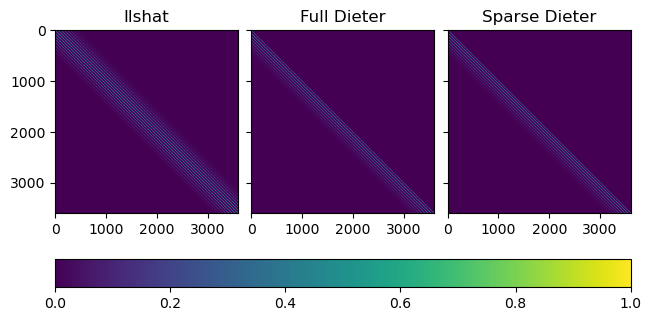

In [6]:
ils = ilshat(*inp)
fdi = full_dieter(*inp)
sdi = sparse_dieter(*inp)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True)
axs[0].set_title('Ilshat')
axs[1].set_title('Full Dieter')
axs[2].set_title('Sparse Dieter')
im = axs[0].imshow(ils, aspect='equal', vmin=0, vmax=1)
axs[1].imshow(fdi, aspect='equal', vmin=0, vmax=1)
axs[2].imshow(sdi, aspect='equal', vmin=0, vmax=1)
fig.colorbar(im, ax=axs, orientation='horizontal')
print(f"Identical: {np.allclose(sp.linalg.cholesky(ils, True), sp.linalg.cholesky(fdi, True))}, ",
      f"{np.allclose(sp.linalg.cholesky(ils, True), sp.linalg.cholesky(sdi, True))}")

In [7]:
%timeit ilshat(*inp)
%timeit full_dieter(*inp)
%timeit sparse_dieter(*inp)

472 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
229 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
205 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%memit ilshat(*inp)
%memit full_dieter(*inp)
%memit sparse_dieter(*inp)

peak memory: 1701.95 MiB, increment: 1058.87 MiB
peak memory: 723.75 MiB, increment: 80.50 MiB
peak memory: 643.25 MiB, increment: 0.00 MiB
